In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [5]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [6]:
include("../test/data.jl")

generate_pattern_dataset (generic function with 1 method)

In [7]:
copy_data = generate_copy_dataset(rng);

In [8]:
cb = generate_codebook(rng);

In [9]:
copy_hd = map_symbols(copy_data, cb);

In [10]:
using MLUtils: BatchView

In [11]:
train_set = BatchView(copy_hd, batchsize= 32)

BatchView([([-0.973732590675354 0.877922534942627 … 0.0 0.0; -0.8487521409988403 0.33038103580474854 … 0.0 0.0; … ; -0.23496782779693604 0.00014984607696533203 … 0.0 0.0; 0.4651527404785156 0.5624576807022095 … 0.0 0.0], [-0.973732590675354 0.877922534942627 … 0.0 0.0; -0.8487521409988403 0.33038103580474854 … 0.0 0.0; … ; -0.23496782779693604 0.00014984607696533203 … 0.0 0.0; 0.4651527404785156 0.5624576807022095 … 0.0 0.0]), ([0.5067107677459717 -0.36566197872161865 … 0.0 0.0; -0.3118159770965576 0.41499102115631104 … 0.0 0.0; … ; 0.45069921016693115 0.09577715396881104 … 0.0 0.0; 0.152640700340271 -0.9376194477081299 … 0.0 0.0], [0.5067107677459717 -0.36566197872161865 … 0.0 0.0; -0.3118159770965576 0.41499102115631104 … 0.0 0.0; … ; 0.45069921016693115 0.09577715396881104 … 0.0 0.0; 0.152640700340271 -0.9376194477081299 … 0.0 0.0]), ([0.877922534942627 -0.1039891242980957 … 0.0 0.0; 0.33038103580474854 0.465531587600708 … 0.0 0.0; … ; 0.00014984607696533203 -0.9983782768249512 … 0.

In [12]:
b = first(train_set) |> stack;

In [13]:
size(b)

(2, 32)

In [14]:
x = b[1,:] |> stack
y = b[2,:] |> stack;

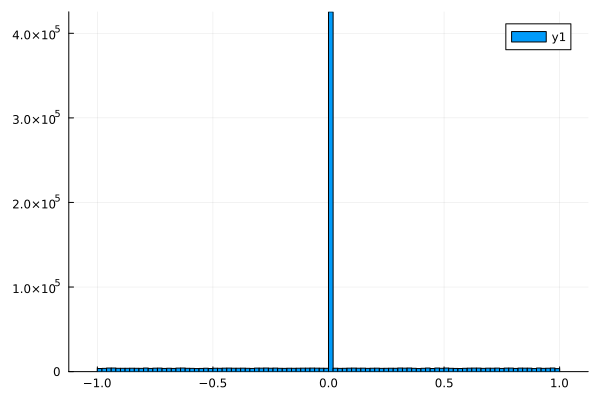

In [15]:
histogram(vec(x))

In [16]:
size(x)

(512, 50, 32)

In [17]:
size(y)

(512, 50, 32)

In [18]:
l = PhasorAttention(3.0f0)

PhasorAttention(3.0f0)  # 1 parameters

In [19]:
ps, st = Lux.setup(rng, l)

((scale = Float32[3.0],), NamedTuple())

In [20]:
typeof(ps)

@NamedTuple{scale::Vector{Float32}}

In [21]:
yh, _ = l(x, x, x, ps, st)

([-0.5846013916593643 0.4985645616605355 … -0.002882989671217547 -0.002882989671217547; -0.413275998053049 0.17539918815092825 … 0.0006166724704823502 0.0006166724704823502; … ; -0.02927909247396762 0.08321908290015621 … 0.008860322638553622 0.008860322638553622; 0.29998699089932157 0.35714812451706157 … 0.006911873473031477 0.006911873473031477;;; 0.15114410173912954 -0.13451862713146603 … -0.0007706825603595994 -0.0007706825603595994; -0.1101946624540515 0.12996016049733597 … -0.0005988053908494045 -0.0005988053908494045; … ; 0.2056178857100556 0.08394800372624255 … 0.004736913746562515 0.004736913746562515; 0.0535861284012553 -0.13700754973534304 … -0.0009444350822682178 -0.0009444350822682178;;; 0.27257439746220136 -0.07749986540626061 … -0.0016675286856330685 -0.0016675286856330685; 0.150773728523708 0.2955272068470438 … 0.0007568221675745228 0.0007568221675745228; … ; -0.01001996830617618 -0.9709626718521777 … -0.0010221164252828378 -0.0010221164252828378; 0.34446171372006706 0.5

In [22]:
yh[1] |> size

()

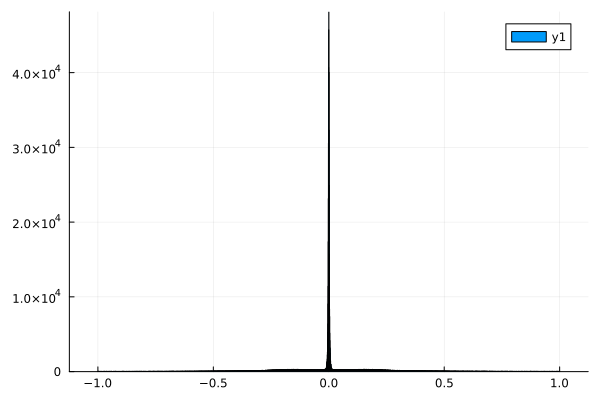

In [23]:
histogram(yh |> vec)

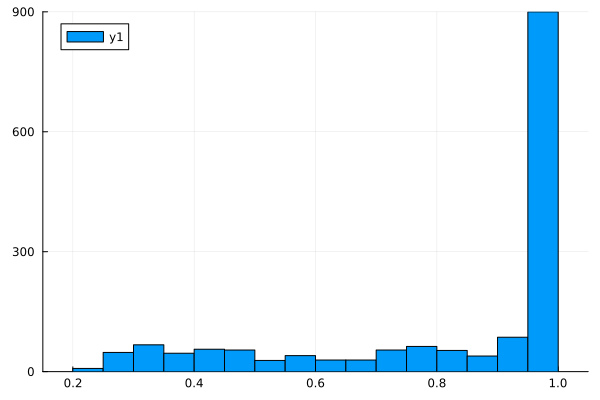

In [24]:
histogram(vec(similarity(yh, x)))